# Color Correction Exercises
## _Color Imaging_
## Ricardo Sapaico
## 2024/04/16
----

### Import necessary Libraries

In [1]:
import os

import colour
import colour_checker_detection
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageCms

### Load Image

Image Size: 4912x3264


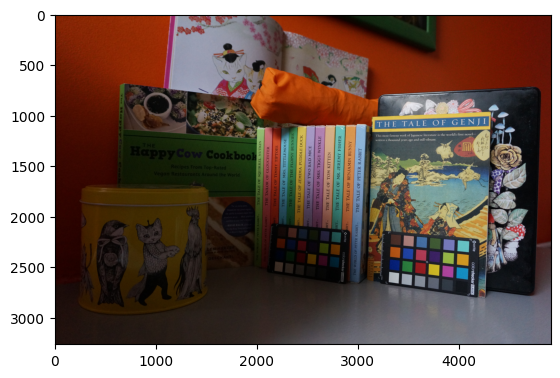

In [55]:
# Input/Output
filepath = r"/Users/kimiaarfaie/Github/Color-Correction/Images"
filename = "DSC00234.JPG"
outpath_base = r"/Users/kimiaarfaie/Github/Color-Correction//color_correction"
outpath = os.path.join(outpath_base, os.path.splitext(filename)[0])
# os.path.splitext("DSC00234.JPG") → ("DSC00234", ".JPG")
os.makedirs(outpath, exist_ok=True)

# Load Input Image: Output image has been normalized between [0,1]
img = Image.open(os.path.join(filepath, filename))
print(f"Image Size: {img.width}x{img.height}")
plt.imshow(img)

# Create an sRGB Profile (used later when saving images)
sRGB_profile = ImageCms.createProfile("sRGB")


In [56]:
# Info about the image
img_arr = np.array(img)
print(img_arr.shape) 
print(img_arr.dtype)
print("Min:", img_arr.min(), "Max:", img_arr.max())

(3264, 4912, 3)
uint8
Min: 0 Max: 255


### Detect ColorChecker

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07537055..1.0809056].


Number of ColorChecker charts detected: 1
Number of patches in ColorChecker chart:  24


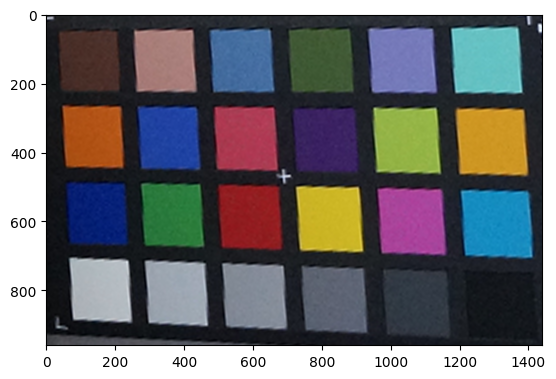

In [ ]:
# The module needs a normalized image, with values in the [0,1] range
img_norm = np.asarray(img) / 255

# Sample Size is the size of a small square area in the center of each color patch
sample_size_rectangle = 75 

# Detect ColourChecker chart(s)
# Set additional_data to True to get masks and segmented ColorChecker image
cc_data = colour_checker_detection.detect_colour_checkers_segmentation(
    img_norm, samples = sample_size_rectangle, additional_data=True 
)

cc_count = len(cc_data)
print("Number of ColorChecker charts detected:", cc_count)

if cc_count == 0:
    raise RuntimeError("No ColorChecker detected.")

# Working with the first detected chart
values = cc_data[0].values

# patch_colors: Get the RGB values of patches
# color_checker_img: Get the detected ColorChecker image (RGB, normalized [0–1])
# patch_position_in_cc: Get masks of the first ColorChecker chart
patch_colors, patch_position_in_cc, color_checker_img, extra_info = values

patch_count = len(patch_position_in_cc)
print("Number of patches in ColorChecker chart: ", patch_count)
plt.imshow(color_checker_img)


Masks of the first ColorChecker chart

Each line contains: y_start:y_end,x_start:x_end
Positions are relative to the detected chart position

In [88]:
print(patch_position_in_cc)

[[  82  157   82  157]
 [  82  157  322  397]
 [  82  157  562  637]
 [  82  157  802  877]
 [  82  157 1042 1117]
 [  82  157 1282 1357]
 [ 322  397   82  157]
 [ 322  397  322  397]
 [ 322  397  562  637]
 [ 322  397  802  877]
 [ 322  397 1042 1117]
 [ 322  397 1282 1357]
 [ 562  637   82  157]
 [ 562  637  322  397]
 [ 562  637  562  637]
 [ 562  637  802  877]
 [ 562  637 1042 1117]
 [ 562  637 1282 1357]
 [ 802  877   82  157]
 [ 802  877  322  397]
 [ 802  877  562  637]
 [ 802  877  802  877]
 [ 802  877 1042 1117]
 [ 802  877 1282 1357]]


In [95]:
patch = color_checker_img[82:157,82:157]
print(img_arr.shape)
print(patch.shape)
print(patch.dtype)
print(np.mean(patch,axis=(0,1)))

(3264, 4912, 3)
(75, 75, 3)
float32
[0.29069474 0.1834459  0.15645812]


## Visualize the detected chart and sample patch means

Extract the mean RGB value in each color patch, and normalize them

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07537055..1.0809056].


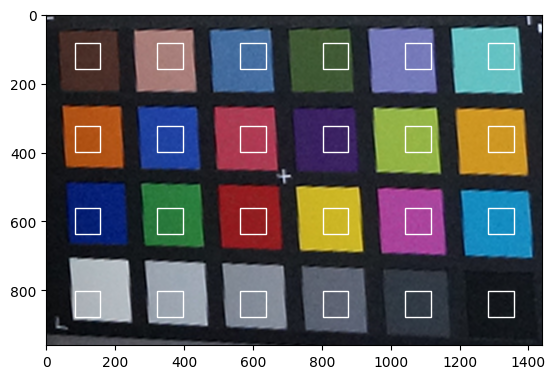

In [96]:
patch_mean_rgb = [] # to store mean RGB values of each patch

fig, ax = plt.subplots(1)
ax.imshow(color_checker_img)

for patch_position in patch_position_in_cc:
    # Get center area of patch (size should be equal to "Sample Size" variable above)
    # when slicing, first index is for rows (y), second index is for columns (x) -> color_checker_img[y0:y1, x0:x1]
    patch = color_checker_img[patch_position[0]:patch_position[1],
            patch_position[2]:patch_position[3]]
    patch_mean_rgb.append(np.mean(patch, axis=(0, 1))) # average over height and width
    
    # Create a Rectangle patch to be drawn Rectangle(xy, width, height)
    rect = patches.Rectangle((patch_position[2], patch_position[0]), \
                             patch_position[3] - patch_position[2], \
                             patch_position[1] - patch_position[0], \
                             linewidth=1, edgecolor='w', facecolor='none')
    ax.add_patch(rect)

# RGB data is already normalized between 0..1 so we just need to create a numpy array
patch_mean_rgb_norm = np.asarray(patch_mean_rgb)  # shape: [m x 3]

# Save normalized RGB mean results to file
np.savetxt(os.path.join(outpath, "rgb_mean_norm_colors.csv"), patch_mean_rgb_norm, fmt="%f", delimiter=",")

In [97]:
print(patch_mean_rgb_norm)

[[0.29069474 0.1834459  0.15645812]
 [0.6601643  0.49911454 0.48150516]
 [0.274329   0.43611485 0.63513   ]
 [0.2522549  0.352464   0.2070361 ]
 [0.46422887 0.4798861  0.7305153 ]
 [0.39866862 0.7628675  0.76715046]
 [0.6894272  0.3195975  0.07782412]
 [0.12414654 0.26025912 0.6369941 ]
 [0.6848322  0.23189874 0.3268468 ]
 [0.23306914 0.13502127 0.38836163]
 [0.5866781  0.70916533 0.27316403]
 [0.8093098  0.593896   0.13818334]
 [0.01875586 0.11951517 0.45217475]
 [0.16415277 0.47899476 0.23532331]
 [0.57290524 0.11307821 0.12599216]
 [0.801373   0.7150362  0.14503884]
 [0.67223704 0.26687136 0.61559725]
 [0.07998702 0.55269456 0.7575618 ]
 [0.6814435  0.70412034 0.7278888 ]
 [0.61403644 0.6476654  0.69041705]
 [0.5134722  0.54491496 0.5953358 ]
 [0.36643532 0.39054614 0.45267692]
 [0.19354427 0.22910576 0.27018666]
 [0.07676449 0.08895599 0.1081045 ]]


### Linearize RGB values of the Patches
A Non-Linear Function was applied to RGB values when the JPEG file was created.\
Calibration won't work well if we use non-linear RGB values!\
Here we are assuming the image is in the sRGB color space.

In [98]:
# The sRGB encoding/decoding functions are piecewise (a small linear section near black and a power-law section for the rest)

# Tone Response Curve of sRGB Color Space
# Input values should be in the [0,1] range
def delinearize(x): # Encoding
    if (x < 0.0031308):
        x_norm = 12.92 * x
    else:
        x_norm = 1.055 * (x ** (1 / 2.4)) - 0.055
    return x_norm


# Inverse of the Tone Response Curve of sRGB Color Space
# Input values should be in the [0,1] range
def linearize(x): # Decoding
    if (x < 0.04045):
        x_norm = x / 12.92
    else:
        x_norm = ((x + 0.055) / 1.055) ** 2.4
    return x_norm

# np.vectorize(linearize) applies the linearize function element-wise to the input array
patch_mean_rgb_norm_linear = np.vectorize(linearize, otypes=[np.float64])(patch_mean_rgb_norm)

# Save normalized RGB mean results to file
np.savetxt(os.path.join(outpath, "rgb_mean_norm_linear_colors.csv"), patch_mean_rgb_norm_linear, fmt="%f",
           delimiter=",")

### Get Reference XYZ and Lab Data of ColorChecker Chart
We need to pay attention that the XYZ data is given with a D65 illuminant\
As this is the same illuminant of the sRGB values used for the color correction

In [ ]:
# Get reference xyY chromaticy coordinates for the ColorChecker Chart
# xyY values correspond to a D50 illuminant
cc_xyY_reference = colour.CCS_COLOURCHECKERS['ColorChecker24 - After November 2014']

# Convert all values from xyY to XYZ
cc_XYZ_reference = colour.xyY_to_XYZ(list(cc_xyY_reference.data.values()))
print("Color Patches:")
print(*list(cc_xyY_reference.data.keys()), sep='\n')

# Chromatic Adaptation of XYZ values as their illuminant was D50
bradford_d50_to_d65 = np.array([[0.9555766, -0.0230393, 0.0631636],
                                [-0.0282895, 1.0099416, 0.0210077],
                                [0.0122982, -0.0204830, 1.3299098]])

cc_XYZ_reference_d65 = bradford_d50_to_d65.dot(cc_XYZ_reference.transpose()).transpose()  # output shape: [m x 3]

# Compute the Lab values under D65 illuminant
illum_D65 = colour.CCS_ILLUMINANTS['CIE 1931 2 Degree Standard Observer']['D65']
cc_Lab_reference = colour.XYZ_to_Lab(cc_XYZ_reference_d65, illum_D65)  # shape: [m x 3]

# Save XYZ and Lab reference of ColorChecker to file
np.savetxt(os.path.join(outpath, "XYZ_reference_ccaft2014_D65.csv"), cc_XYZ_reference_d65, fmt="%f", delimiter=",")
np.savetxt(os.path.join(outpath, "Lab_reference_ccaft2014_D65.csv"), cc_Lab_reference, fmt="%f", delimiter=",")

Color Patches:
dark skin
light skin
blue sky
foliage
blue flower
bluish green
orange
purplish blue
moderate red
purple
yellow green
orange yellow
blue
green
red
yellow
magenta
cyan
white 9.5 (.05 D)
neutral 8 (.23 D)
neutral 6.5 (.44 D)
neutral 5 (.70 D)
neutral 3.5 (1.05 D)
black 2 (1.5 D)


cc_xyY_reference → a ColourChecker object

cc_xyY_reference.data → an Ordered Dictionary

cc_xyY_reference = ColourChecker(
    name = "ColorChecker24 - After November 2014",
    illuminant = "D50",
    rows = 4,
    columns = 6,
    data = OrderedDict({
        "dark skin":  [0.4002, 0.3504, 0.100],
        "light skin": [0.3773, 0.3446, 0.352],
        "blue sky":   [0.2470, 0.2514, 0.183],
        ...
    })
)

In [121]:
print("Chart name:", cc_xyY_reference.name)
print("Illuminant:", cc_xyY_reference.illuminant)
print("Rows x Columns:", cc_xyY_reference.rows, "x", cc_xyY_reference.columns)

print("Type of data:", type(cc_xyY_reference.data))
print("5th Patch :", list(cc_xyY_reference.data.items())[4])

print("First 3 entries:")
for k, v in list(cc_xyY_reference.data.items())[:3]:
    print(f"{k}: {v}")


Chart name: ColorChecker24 - After November 2014
Illuminant: [0.34570291 0.3585386 ]
Rows x Columns: 4 x 6
Type of data: <class 'dict'>
5th Patch : ('blue flower', array([0.30289052, 0.28628691, 0.2287176 ]))
First 3 entries:
dark skin: [0.4374836  0.37852284 0.09832436]
light skin: [0.42224944 0.37249369 0.3362023 ]
blue sky: [0.27614744 0.29838157 0.17855193]


### Let's just check one of the patches in the ColorChecker Chart
__[http://colorizer.org/](http://colorizer.org/)__

orange yellow:
x=0.494, y=0.444, Y=0.429
X=0.477, Y=0.429, Z=0.060
L=71.510, a=20.137, b=74.756


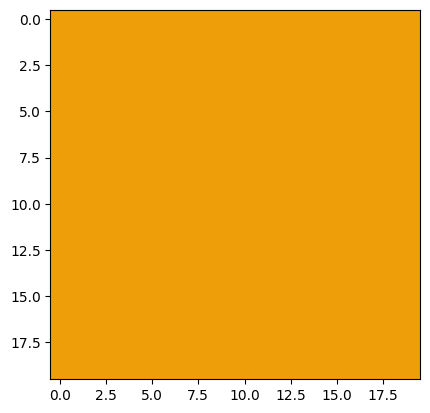

In [132]:
# Check for instance xyY, XYZ and Lab (D65) of "Foliage"
# Does it look correct to you?
xyY_OY = cc_xyY_reference.data['orange yellow']
XYZ_OY = colour.xyY_to_XYZ(xyY_OY)
Lab_OY = colour.XYZ_to_Lab(XYZ_OY, illuminant=illum_D65)
print("orange yellow:")
print("x={:.3f}, y={:.3f}, Y={:.3f}".format(xyY_OY[0], xyY_OY[1], xyY_OY[2]))
print("X={:.3f}, Y={:.3f}, Z={:.3f}".format(XYZ_OY[0], XYZ_OY[1], XYZ_OY[2]))
print("L={:.3f}, a={:.3f}, b={:.3f}".format(Lab_OY[0], Lab_OY[1], Lab_OY[2]))

patch_view = colour.XYZ_to_sRGB(XYZ_OY) * np.ones((20, 20, 3), dtype=np.float64)
plt.imshow(patch_view)


## Color Correction
### If you remember, the equation we need to solve is: $X=MP$, and its solution is: $M=XP^T(PP^T)^{-1}$
### where:
- X shape = 3 x m (m is number of Reference points)
- M shape = 3 x N (N depends on the correction method)
- P shape = N x m

$m = 24$ because we are using the ColorChecker Chart

X is the reference points (XYZ values)

P is the values from the image / camera

M is the transformation matrix we want to find

### Get X matrix (Reference XYZ information) in the expected shape

In [75]:
X = cc_XYZ_reference_d65.transpose()  # shape: [3 x m]
print(X.shape)

(3, 24)


### Get a Matrix containing all image pixels, normalized and linearized

In [133]:
print(img_norm.shape)
img_all_rgb_values = (img_norm.reshape(-1, img_norm.shape[-1])).transpose()  # shape: [3 x Width*Height]
img_all_rgb_values_norm_linear = np.vectorize(linearize, otypes=[np.float64])(img_all_rgb_values)
print(img_all_rgb_values.shape)

(3264, 4912, 3)
(3, 16032768)


### LINEAR CORRECTION
#### In this case, N=3

In [ ]:
# Get P
P_linear = patch_mean_rgb_norm_linear.transpose()  # shape: [3 x 24]
# Solve equation and compute M
t1 = P_linear.dot(P_linear.transpose())
t2 = np.linalg.inv(t1) 
t3 = (P_linear.transpose()).dot(t2)
M_linear = X.dot(t3)  # correction matrix, shape: [3 x 3]
# Save correction matrix to file
print(M_linear)
np.savetxt(os.path.join(outpath, "CorrMatrix_Linear.csv"), M_linear, fmt="%f", delimiter=",")

[[0.68210775 0.34785283 0.24759117]
 [0.43290417 0.75888566 0.14526508]
 [0.15741387 0.08402092 0.96968972]]


#### Use Correction to Predict XYZ corrected data for the entire image
##### It might take a while if image is Large!

In [ ]:
# Predict XYZ values (already in D65, same illuminant as sRGB)
img_XYZ_values_corrected = M_linear.dot(img_all_rgb_values_norm_linear)  # shape: [3 x Width*Height]

# Convert from XYZ to sRGB
matrix_XYZ_to_sRGB = np.array([[3.2404542, -1.5371385, -0.4985314],
                               [-0.9692660, 1.8760108, 0.0415560],
                               [0.0556434, -0.2040259, 1.0572252]])

img_RGB_values_from_XYZ = matrix_XYZ_to_sRGB.dot(img_XYZ_values_corrected)

# Apply sRGB Tone Response Curve
img_RGB_values_corrected = np.vectorize(delinearize, otypes=[np.float64])(img_RGB_values_from_XYZ)

# Rescale to 0..255
img_RGB_linear = 255 * img_RGB_values_corrected

# Clip the values in case there are unexpected values
img_RGB_linear[img_RGB_linear < 0] = 0
img_RGB_linear[img_RGB_linear > 255] = 255

# Convert to uint8
img_RGB_uint8_linear = img_RGB_linear.astype(np.uint8)

# Reshape to [Width x Height x 3]
img_RGB_linear_reshaped = img_RGB_uint8_linear.transpose().reshape((img.height, img.width, -1))
print(img_RGB_linear_reshaped.shape)

# And save
Image.Image.save(Image.fromarray(img_RGB_linear_reshaped, mode='RGB'),
                 os.path.join(outpath, 'image_corrected_Linear.jpg'),
                 icc_profile=ImageCms.ImageCmsProfile(sRGB_profile).tobytes(),
                 quality=95, subsampling=0)

(3264, 4912, 3)


#### Use Correction to Predict XYZ corrected data for the 24 Patches of the ColorChecker Chart

Average delta-E 2000:  5.320713134956923


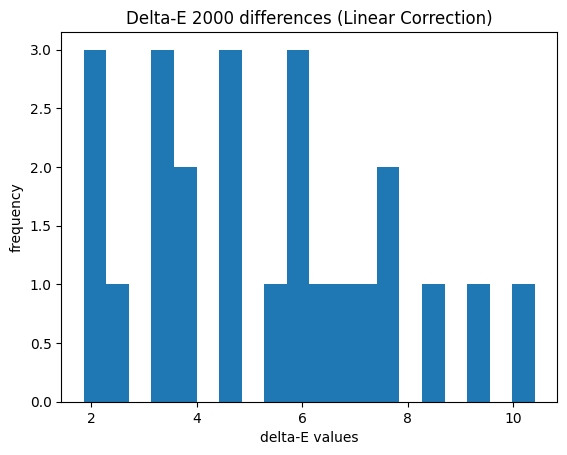

In [ ]:
# Predict XYZ values (already in D65, same illuminant as Reference)
cc_XYZ_corrected_linear = M_linear.dot(P_linear)  # shape: [3 x 24]

# Convert to Lab
cc_Lab_corrected_linear = colour.XYZ_to_Lab(cc_XYZ_corrected_linear.transpose(), illum_D65)  # shape: [24 x 3]

# Compute delta-E with reference XYZ data
cc_dE00_linear = colour.difference.delta_E_CIE2000(cc_Lab_reference, cc_Lab_corrected_linear)

# Show histogram of delta-E values
plt.hist(cc_dE00_linear, bins=20)
plt.title("Delta-E 2000 differences (Linear Correction)")
plt.xlabel("delta-E values")
plt.ylabel("frequency")
print("Average delta-E 2000: ", np.mean(cc_dE00_linear))
np.savetxt(os.path.join(outpath, "DeltaE2000_Linear.csv"), cc_dE00_linear, fmt="%f", delimiter=",")

### POLYNOMIAL (2ND DEGREE) CORRECTION

$X = MP$

where $P =[R,G,B,R^2,G^2,B^2,RG,RB,GB]^T$

#### Compute Correction Matrix
Polynomial order is N=9

In [80]:
# Get P
# But before compute additional data: R^2, G^2, B^2, RG, RB, GB
rgb_sq = P_linear ** 2
rgrbgb = np.vstack((P_linear[0, :] * P_linear[1, :], P_linear[0, :] * P_linear[2, :], P_linear[1, :] * P_linear[2, :]))
P_poly2nd = np.concatenate((P_linear, rgb_sq, rgrbgb))  # shape: [9 x m]
# Solve equation and compute M
t1 = P_poly2nd.dot(P_poly2nd.transpose())
t2 = np.linalg.inv(t1)
t3 = (P_poly2nd.transpose()).dot(t2)
M_poly2nd = X.dot(t3)  # correction matrix, shape: [3 x 9]
# Save correction matrix to file
print(M_poly2nd)
np.savetxt(os.path.join(outpath, "CorrMatrix_Poly2nd.csv"), M_poly2nd, fmt="%f", delimiter=",")

[[ 0.88897469  0.25743806  0.34952915 -0.98956937 -1.41164688 -0.91830038
   1.90527334  0.15334813  1.53803728]
 [ 0.55493893  0.78154009  0.21073143 -0.87236294 -1.55047943 -0.8880914
   1.8403894   0.37354536  1.44686794]
 [ 0.20539876 -0.16007371  1.36421784 -0.87469849 -1.32375525 -1.70746266
   2.26226066  0.47216596  1.82811063]]


#### Apply Correction to Image

In [81]:
# Generating extra rgb data (R^2, G^2, B^2, RG, RB, GB)
img_all_rgb_values_norm_linear_sq = img_all_rgb_values_norm_linear ** 2
img_all_rgb_values_norm_linear_rgrbgb = np.vstack(
    (img_all_rgb_values_norm_linear[0, :] * img_all_rgb_values_norm_linear[1, :],
     img_all_rgb_values_norm_linear[0, :] * img_all_rgb_values_norm_linear[2, :],
     img_all_rgb_values_norm_linear[1, :] * img_all_rgb_values_norm_linear[2, :]))
img_all_rgb_values_norm_linear_poly2nd = np.concatenate(
    (img_all_rgb_values_norm_linear, img_all_rgb_values_norm_linear_sq,
     img_all_rgb_values_norm_linear_rgrbgb))  # shape: [9 x Width*Height]
# Predict XYZ values (already in D65, same illuminant as sRGB)
img_XYZ_values_corrected_poly2nd = M_poly2nd.dot(img_all_rgb_values_norm_linear_poly2nd)  # shape: [3 x Width*Height]
# Convert from XYZ to sRGB
matrix_XYZ_to_sRGB = np.array([[3.2404542, -1.5371385, -0.4985314],
                               [-0.9692660, 1.8760108, 0.0415560],
                               [0.0556434, -0.2040259, 1.0572252]])
img_RGB_values_from_XYZ_poly2nd = matrix_XYZ_to_sRGB.dot(img_XYZ_values_corrected_poly2nd)
# Apply sRGB Tone Response Curve
img_RGB_values_corrected_poly2nd = np.vectorize(delinearize, otypes=[np.float64])(img_RGB_values_from_XYZ_poly2nd)
# Rescale to 0..255
img_RGB_poly2nd = 255 * img_RGB_values_corrected_poly2nd
# Clip the values in case there are unexpected values
img_RGB_poly2nd[img_RGB_poly2nd < 0] = 0
img_RGB_poly2nd[img_RGB_poly2nd > 255] = 255
# Convert to uint8
img_RGB_uint8_poly2nd = img_RGB_poly2nd.astype(np.uint8)
# Reshape to [Width x Height x 3]
img_RGB_reshaped_poly2nd = img_RGB_uint8_poly2nd.transpose().reshape((img.height, img.width, -1))
print(img_RGB_reshaped_poly2nd.shape)
# And save
Image.Image.save(Image.fromarray(img_RGB_reshaped_poly2nd, mode='RGB'),
                 os.path.join(outpath, 'image_corrected_Poly2nd.jpg'),
                 icc_profile=ImageCms.ImageCmsProfile(sRGB_profile).tobytes(),
                 quality=95, subsampling=0)

(3264, 4912, 3)


#### Predict Color of the ColorChecker and Compute Color Difference

Average delta-E 2000:  5.57723983193799


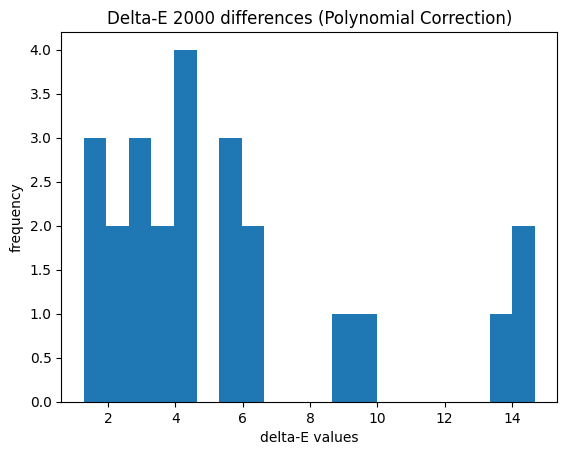

In [82]:
# Predict XYZ values (already in D65, same illuminant as Reference)
cc_XYZ_corrected_poly2nd = M_poly2nd.dot(P_poly2nd)  # shape: [3 x 24]
# Convert to Lab
cc_Lab_corrected_poly2nd = colour.XYZ_to_Lab(cc_XYZ_corrected_poly2nd.transpose(), illum_D65)  # shape: [24 x 3]
# Compute delta-E with reference XYZ data
cc_dE00_poly2nd = colour.difference.delta_E_CIE2000(cc_Lab_reference, cc_Lab_corrected_poly2nd)
# Show histogram of delta-E values
plt.hist(cc_dE00_poly2nd, bins=20)
plt.title("Delta-E 2000 differences (Polynomial Correction)")
plt.xlabel("delta-E values")
plt.ylabel("frequency")
print("Average delta-E 2000: ", np.mean(cc_dE00_poly2nd))
np.savetxt(os.path.join(outpath, "DeltaE2000_Polynomial.csv"), cc_dE00_poly2nd, fmt="%f", delimiter=",")

### Root Polynomial (2nd degree) Correction
#### In this case, N=6

In [83]:
# Get P
# But before compute additional data: (RG)^0.5, (GB)^0.5, (RB)^0.5
rgb_sqrt = np.sqrt(
    np.vstack((P_linear[0, :] * P_linear[1, :], P_linear[1, :] * P_linear[2, :], P_linear[0, :] * P_linear[2, :])))

P_root2nd = np.concatenate((P_linear, rgb_sqrt))  # shape: [6 x m]# Solve equation and compute M
t1 = P_root2nd.dot(P_root2nd.transpose())
t2 = np.linalg.inv(t1)
t3 = (P_root2nd.transpose()).dot(t2)
M_root2nd = X.dot(t3)  # correction matrix, shape: [3 x 6]
# Save correction matrix to file
print(M_root2nd)
np.savetxt(os.path.join(outpath, "CorrMatrix_Root2nd.csv"), M_root2nd, fmt="%f", delimiter=",")

[[ 0.33830147 -0.61450703 -0.16142218  1.01735316  0.90883509 -0.00436899]
 [ 0.05844452 -0.19708955 -0.26411705  1.04189287  0.86662284  0.0481824 ]
 [-0.38605033 -1.03606012  0.54220477  1.35795624  0.84108802  0.16524728]]


#### Apply Correction to Image

In [84]:
# Generating extra rgb data ((RG)^0.5, (GB)^0.5, (RB)^0.5)
img_all_rgb_values_norm_linear_sqrt = np.sqrt(
    np.vstack((img_all_rgb_values_norm_linear[0, :] * img_all_rgb_values_norm_linear[1, :],
               img_all_rgb_values_norm_linear[1, :] * img_all_rgb_values_norm_linear[2, :],
               img_all_rgb_values_norm_linear[0, :] * img_all_rgb_values_norm_linear[2, :])))

img_all_rgb_values_norm_linear_root2nd = np.concatenate(
    (img_all_rgb_values_norm_linear, img_all_rgb_values_norm_linear_sqrt))  # shape: [6 x Width*Height]

# Predict XYZ values (already in D65, same illuminant as sRGB)
img_XYZ_values_corrected_root2nd = M_root2nd.dot(img_all_rgb_values_norm_linear_root2nd)  # shape: [3 x Width*Height]
# Convert from XYZ to sRGB
matrix_XYZ_to_sRGB = np.array([[3.2404542, -1.5371385, -0.4985314],
                               [-0.9692660, 1.8760108, 0.0415560],
                               [0.0556434, -0.2040259, 1.0572252]])
img_RGB_values_from_XYZ_root2nd = matrix_XYZ_to_sRGB.dot(img_XYZ_values_corrected_root2nd)
# Apply sRGB Tone Response Curve
img_RGB_values_corrected_root2nd = np.vectorize(delinearize, otypes=[np.float64])(img_RGB_values_from_XYZ_root2nd)
# Rescale to 0..255
img_RGB_root2nd = 255 * img_RGB_values_corrected_root2nd
# Clip the values in case there are unexpected values
img_RGB_root2nd[img_RGB_root2nd < 0] = 0
img_RGB_root2nd[img_RGB_root2nd > 255] = 255
# Convert to uint8
img_RGB_uint8_root2nd = img_RGB_root2nd.astype(np.uint8)
# Reshape to [Width x Height x 3]
img_RGB_reshaped_root2nd = img_RGB_uint8_root2nd.transpose().reshape((img.height, img.width, -1))
print(img_RGB_reshaped_root2nd.shape)
# And save
Image.Image.save(Image.fromarray(img_RGB_reshaped_root2nd, mode='RGB'),
                 os.path.join(outpath, 'image_corrected_Root2nd.jpg'),
                 icc_profile=ImageCms.ImageCmsProfile(sRGB_profile).tobytes(),
                 quality=95, subsampling=0)

(3264, 4912, 3)


#### Predict Color of the ColorChecker and Compute Color Difference

Average delta-E 2000:  6.891394733160214


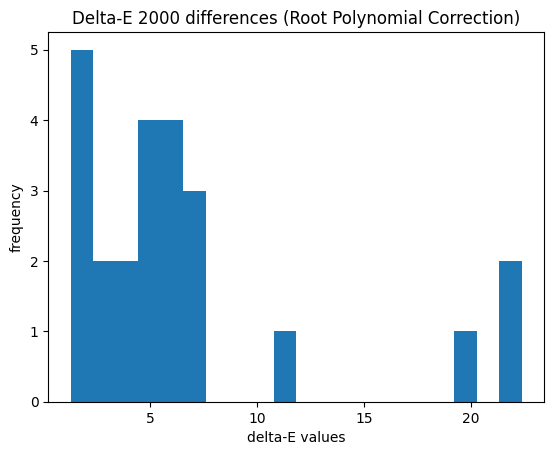

In [85]:
# Predict XYZ values (already in D65, same illuminant as Reference)
cc_XYZ_corrected_root2nd = M_root2nd.dot(P_root2nd)  # shape: [3 x 24]
# Convert to Lab
cc_Lab_corrected_root2nd = colour.XYZ_to_Lab(cc_XYZ_corrected_root2nd.transpose(), illum_D65)  # shape: [24 x 3]
# Compute delta-E with reference XYZ data
cc_dE00_root2nd = colour.difference.delta_E_CIE2000(cc_Lab_reference, cc_Lab_corrected_root2nd)
# Show histogram of delta-E values
plt.hist(cc_dE00_root2nd, bins=20)
plt.title("Delta-E 2000 differences (Root Polynomial Correction)")
plt.xlabel("delta-E values")
plt.ylabel("frequency")
print("Average delta-E 2000: ", np.mean(cc_dE00_root2nd))
np.savetxt(os.path.join(outpath, "DeltaE2000_RootPolynomial.csv"), cc_dE00_root2nd, fmt="%f", delimiter=",")

### Delta-E 2000 between camera-generated JPEG (without correction) and Reference

Average delta-E 2000:  27.031623542054877


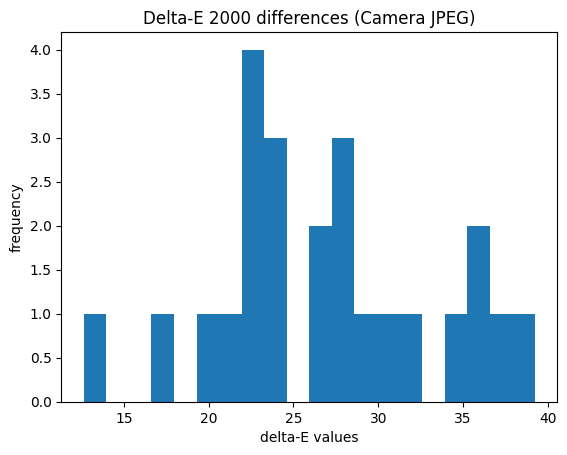

In [86]:
patch_mean_xyz = colour.sRGB_to_XYZ(patch_mean_rgb_norm_linear)
patch_mean_lab = colour.XYZ_to_Lab(patch_mean_xyz)
# Compute delta-E with reference XYZ data
cc_dE00_jpeg = colour.difference.delta_E_CIE2000(cc_Lab_reference, patch_mean_lab)
# Show histogram of delta-E values
plt.hist(cc_dE00_jpeg, bins=20)
plt.title("Delta-E 2000 differences (Camera JPEG)")
plt.xlabel("delta-E values")
plt.ylabel("frequency")
print("Average delta-E 2000: ", np.mean(cc_dE00_jpeg))
np.savetxt(os.path.join(outpath, "DeltaE2000_CameraJPEG.csv"), cc_dE00_jpeg, fmt="%f", delimiter=",")